# Why do 20% of scheduled appointments result in no-shows?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This [Kaggle dataset](https://www.kaggle.com/joniarroba/noshowappointments) contains information from more than 110k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment.

Here are the column descriptions from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments/home), with minor edits for clarity:
* **PatientId** = Identification of a patient
* **AppointmentID** = Identification of each appointment
* **Gender** = Male or Female
* **ScheduledDay** = The day the patient scheduled the appointment (should be before AppointmentDay)
* **AppointmentDay** = The day of the actual appointment, when they have to visit the doctor
* **Age** = The age of the patient
* **Neighbourhood** = Where the appointment takes place i.e. the location of the hospital
* **Scholarship** = True of False, indicates whether or not the patient is enrolled in Brasilian welfare program [Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)
* **Hipertension** = True or False
* **Diabetes** = True or False
* **Alcoholism** = True or False
* **Handcap** = True or False
* **SMS_received** = 1 or more messages sent to the patient
* **No-show** = This is our dependent variable, it says 'No' if the patient showed up to their appointment and 'Yes' if they did not show up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [2]:
# How many No-shows and Shows are there in this dataset?
df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

In [3]:
# What many total records are there in the No-show column?
len(df['No-show'])

110527

In [4]:
# Proportion of No-shows
df['No-show'].value_counts() / len(df['No-show'])

No     0.798067
Yes    0.201933
Name: No-show, dtype: float64

As you can see above, this dataset contains information on more than 110,000 appointments, and more than 20% of them were no-shows. 

The rest of this notebook will explore which factors (aka independent variables) have the largest impact on whether or not someone shows up for their appointment, and how the no-show rate could be improved (i.e. lowered).

Questions that will be explored include:
* **Gender:** How does gender affect no-show rates?
* **Day of Week:** Do certain days of the week have disproportionately higher no-show rates?
* **Age:** Do certain age groups have a disproportionately higher or lower rate of no-shows?
* **Date Difference:** Does how far in advance an appointment is scheduled affect no-show rates?
* **SMS Reminders:** Do SMS reminders decrease no-show rates?

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [5]:
# Assessing data
display(df.head())
display(df.describe())
display(df.info())

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


None

Evaluation of data cleanliness:
* **No missing data:** As we can see from, all of our columns contain exactly 110527 values.
* **Column name inconsistency:** Some column names are [upper camel case](https://en.wikipedia.org/wiki/Camel_case) (e.g. `ScheduledDay`), while others are [snake case](https://en.wikipedia.org/wiki/Snake_case) (e.g. `SMS_received`). There are also inconsistencies with upper and lower case. For this analysis, we'll make all the column names snake case and lower case.
* **Misspellings:** The column titles `Hipertension` and `Handcap` are misspelled.
* **Inconsistent data types:** `PatientId` and `AppointmentID` are both unique identifiers, and they should be the same data type. In this case, they should both be integers, so we should change `PatientId` from float64 to int64.
* **Incorrect data types:** Right now `ScheduledDay` and `AppointmentDay` are strings, but they should be converted to datetime.
* **Impossible data:** We can see a minimum value for Age of -1. Age cannot be negative, so we should drop any rows containing a negative `Age` value.
* **Dependent variable format:** Since the `No-show` column is our dependent variable and is a boolean with the value of "Yes" or "No", it would be easier to convert "Yes" to 1 and "No" to 0 when calculating means and proportions.

### Data Cleaning

Let's first create a copy of our dataframe, which we will clean and use for our analysis.

In [6]:
# Let's create a copy of our dataframe, which will be our cleaned version.
df_clean = df.copy()

Let's fix our column names by making them all lower case and snake case, and correcting all typos.

In [7]:
# Change column names to lower case
df_clean.columns = df.columns.str.lower()

# Fix typos and change column names to snake case notation
df_clean.rename(columns={'patientid': 'patient_id', 
                   'appointmentid': 'appointment_id', 
                   'scheduledday': 'scheduled_day', 
                   'appointmentday': 'appointment_day',
                   'neighbourhood': 'neighborhood',
                   'hipertension': 'hypertension',
                   'handcap': 'handicap',
                   'no-show': 'no_show'
                  }, inplace=True)

# Verify the changes we just made
df_clean.columns

Index(['patient_id', 'appointment_id', 'gender', 'scheduled_day',
       'appointment_day', 'age', 'neighborhood', 'scholarship', 'hypertension',
       'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show'],
      dtype='object')

Next, we will make sure all of our data types are converted to the correct type:

In [8]:
# Change the data type of patient_id from float to integer
df_clean['patient_id'] = df_clean['patient_id'].astype('int64')

# Change the data type of both scheduled_day and appointment_day fromt string (object) to datetime
df_clean['scheduled_day'] = pd.to_datetime(df_clean['scheduled_day'])
df_clean['appointment_day']  = pd.to_datetime(df_clean['appointment_day'])

# Verify changes
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null int64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null datetime64[ns]
appointment_day    110527 non-null datetime64[ns]
age                110527 non-null int64
neighborhood       110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: datetime64[ns](2), int64(9), object(3)
memory usage: 11.8+ MB


In the next few rows, we'll find and drop any rows with negative `age` values.

In [9]:
# Inspect rows with negative age values
df_clean[df_clean['age'] < 0]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
99832,465943158731293,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No


In [10]:
# Drop rows with negative age values, and verify the change in the row count
df_clean = df_clean[df_clean.age >= 0]
df_clean.shape

(110526, 14)

For consistency, let's make `scheduled_day` and `appointment_day` only show calendar dates, with no time values

In [11]:
# Extract the calendar date portion of scheduled_day, and then convert it back to datetime
df_clean.scheduled_day = pd.to_datetime(df_clean.scheduled_day.dt.date)

In [12]:
# Verify that scheduled_day and appointment_day now only show calendar date, and their types are both datetime
display(df_clean.head())
display(df_clean.info())

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110526 non-null int64
appointment_id     110526 non-null int64
gender             110526 non-null object
scheduled_day      110526 non-null datetime64[ns]
appointment_day    110526 non-null datetime64[ns]
age                110526 non-null int64
neighborhood       110526 non-null object
scholarship        110526 non-null int64
hypertension       110526 non-null int64
diabetes           110526 non-null int64
alcoholism         110526 non-null int64
handicap           110526 non-null int64
sms_received       110526 non-null int64
no_show            110526 non-null object
dtypes: datetime64[ns](2), int64(9), object(3)
memory usage: 12.6+ MB


None

Let's find and drop all rows where `appointment_day` is before `scheduled_day`

In [13]:
# Check for rows where the calendar date of scheduled_day is after appointment_day
df_clean[df_clean.appointment_day < df_clean.scheduled_day]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
27033,7839272661752,5679978,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes
55226,7896293967868,5715660,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes
64175,24252258389979,5664962,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes
71533,998231581612122,5686628,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes
72362,3787481966821,5655637,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes


In [14]:
# Drop rows where scheduled day is after appointment day
df_clean = df_clean[df_clean.appointment_day >= df_clean.scheduled_day]

In [15]:
# Verify our changes, total row count should now be 110521
df_clean.shape

(110521, 14)

Lastly, we'll create a new column that converts the `no_show` column into 0's and 1's for easier aggregation.

In [16]:
# Create new column displaying no_show as 0 or 1
df_clean['no_show_int'] = 0
df_clean['no_show_int'].loc[df_clean['no_show'] == 'Yes'] = 1
df_clean.head()

/Users/petershin/miniconda2/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,no_show_int
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


<a id='eda'></a>
## Exploratory Data Analysis

In [17]:
# For convenience, let's create some shorthand to refer to all Show rows and No Show rows, respectively.
show = df_clean.no_show == 'No'
no_show = df_clean.no_show == 'Yes'

### Question #1: Gender
**How does gender affect no-show rates?**

Let's start off with a simple question. Are there any differences in no-show rates between men and women? This is worth exploring because women and men (in aggregate) could have different work schedules or family commitments, which could affect their ability to show up to appointments.

First, we'll look at the total count and proportion of appointments by gender.

In [18]:
# Total appointments by gender
df_clean.gender.value_counts()

F    71836
M    38685
Name: gender, dtype: int64

In [19]:
# Proportion of total appointments by gender
df_clean.gender.value_counts() / df_clean.shape[0]

F    0.649976
M    0.350024
Name: gender, dtype: float64

We can see above that roughly two-thirds of all appointments are for female patients.

Now, let's look at no-show rates by gender.

In [20]:
# No-show rates by gender
df_clean.groupby('gender', as_index=False).no_show_int.mean()

,gender,no_show_int
0,F,0.203115
1,M,0.199638


Interestingly, the no-show rate for women and men is nearly identical, at around 20% for each.

We can safely conclude that gender by itself has no meaningful impact on no-show rates.

### Question #2: Day of Week
**Do certain days of the week have disproportionately higher no-show rates?**

Next, let's see if the day of the week affects no-show rates.

For example, people's daily schedules on weekdays tend to be different from their schedules on weekends, so we might expect no-show rates to differ between weekdays and weekends.

For this analysis, we'll have to create a new column showing the day of the week for each value in in appointment_day

In [21]:
# Create a new column for day of week of each appointment
df_clean['appointment_dow'] = df_clean.appointment_day.dt.dayofweek
df_clean.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,no_show_int,appointment_dow
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,4
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,4
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,4
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,4
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,4


This gives us a column with possible values between 0 and 6, where Monday=0 and Sunday=6

Now let's group by this new column to see no-show rates by the day of the week.

In [22]:
df_clean.groupby('appointment_dow').no_show_int.mean()

appointment_dow
0    0.206446
1    0.200874
2    0.196861
3    0.193494
4    0.212261
5    0.230769
Name: no_show_int, dtype: float64

This table tells us two things.

First, there are no appointments on Sundays i.e. `appointment_dow` = 6. This is probably because hospitals in this region of Brazil are closed.

Second, there doesn't seem to be any major differences in no-show rates by the day of the week. They are all around 20%, with the exception of Saturday which is 23%.

In order to know if 23% is a meaningful difference, we would also need to know how many appointments take place on Saturdays, and on each day of the week in general.

In [23]:
# Total appointments by day of week
df_clean.groupby('appointment_dow').appointment_id.count()

appointment_dow
0    22713
1    25638
2    25866
3    17246
4    19019
5       39
Name: appointment_id, dtype: int64

This makes it very clear that almost no appointments happen on Saturdays, and so the higher No-show rate of 23% on Saturdays is not meaningful. The very few that did happen must have been for some kind of emergency or other rare exception.

Let's visualize this table.

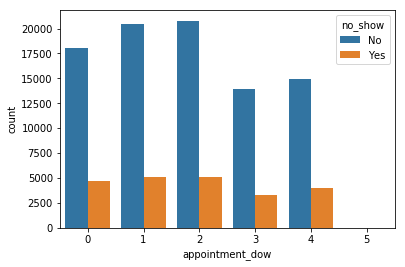

In [24]:
# Bar plot of total appointments by day of week
sb.countplot(
    data = df_clean,
    x = 'appointment_dow',
    hue = 'no_show'
);

This visualization shows us that more appointments take place on Tuesdays and Wednesdays, and less take place on Thursdays and Fridays, especially for people who showed up.

However, it's harder to see the differences for No-shows, due to the imbalance in the absolute number of Shows and No-shows, which make up roughly 80% and 20% of all appointments, respectively.

To improve this visualization, rather than the counts of Shows and No-shows, we'll instead look at the proportions of Shows and No-shows for each day of the week, so that Shows and No-shows are normalized and easier to compare.

First, let's get the proportions for Shows:

In [25]:
# Show totals by day of week
s_dow_totals = df_clean[show].groupby('appointment_dow').appointment_id.count()

# Show total
s_total = df_clean[show].appointment_id.count()

# Show proportion by day of week
s_p = s_dow_totals / s_total

# Add a row for Sunday, for the visualization
s_p['6'] = 0

s_p

appointment_dow
0    0.204338
1    0.232272
2    0.235514
3    0.157686
4    0.169850
5    0.000340
6    0.000000
Name: appointment_id, dtype: float64

We'll do the same for No-shows:

In [26]:
# No-show totals by day of week
ns_dow_totals = df_clean[no_show].groupby('appointment_dow').appointment_id.count()

# No-show total
ns_total = df_clean[no_show].appointment_id.count()

# No-show proportion by day of week
ns_p = ns_dow_totals / ns_total

# Add a row for Sunday, for the visualization
ns_p['6'] = 0

ns_p

appointment_dow
0    0.210137
1    0.230797
2    0.228198
3    0.149547
4    0.180918
5    0.000403
6    0.000000
Name: appointment_id, dtype: float64

In [27]:
# X locations for the groups
ind = np.arange(len(ns_p))

# Width of the bars
width = 0.35

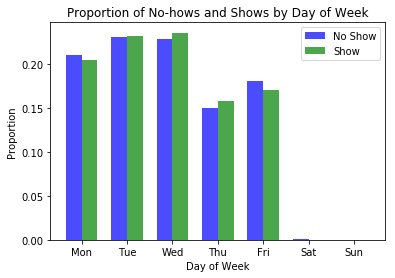

In [28]:
# plot bars
red_bars = plt.bar(ind, ns_p, width, color='b', alpha=.7, label='No Show')
white_bars = plt.bar(ind + width, s_p, width, color='g', alpha=.7, label='Show')

# title and labels
plt.ylabel('Proportion')
plt.xlabel('Day of Week')
plt.title('Proportion of No-hows and Shows by Day of Week')
locations = ind + width / 2  # xtick locations
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']  # xtick labels
plt.xticks(locations, labels)

# legend
plt.legend();

That looks much nicer than our initial visualization.

In addition to the fact that almost no appointments happen on the weekend, we can also see that the total proportion of Show appointments and No-show appointments by day of the week is quite similar.

Based on everything we've seen, we can conclude that there is no association between the day of the week and No-shows.

### Question #3: Age
**Do certain age groups have a disproportionately higher or lower rate of no-shows?**

Age could be a factor because, similar to gender, there probably are significant differences in lifestyle and personal schedules between different age groups, which could in turn affect their No-show rates.

First, let's compare the average age for Shows vs No-shows.

In [29]:
df_clean[show].age.mean(), df_clean[no_show].age.mean()

(37.790504154999034, 34.31787218786412)

We can see here that, on average, Shows are about 38 years old and No-shows are about 34 years old.

That doesn't seem like a huge difference, but let's see if the distribution of ages for Shows and No-shows reveals more insights.

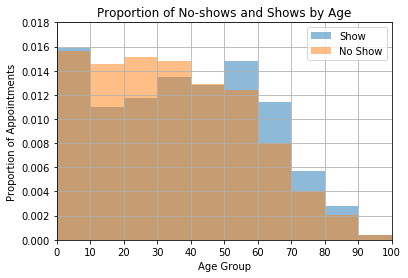

In [30]:
# Comparing histogram of ages of Shows vs No Shows
df_clean[show].age.hist(alpha=0.5, density=True, label='Show', bins=range(0, max(df_clean[show].age) + 10, 10));
df_clean[no_show].age.hist(alpha=0.5, density=True, label='No Show', bins=range(0, max(df_clean[no_show].age) + 10, 10));
plt.xticks(np.arange(0, max(df_clean[show].age) + 10, 10))
plt.axis([0, 100, 0, 0.018])
plt.legend();

# Labels and titles
plt.xlabel('Age Group')
plt.ylabel('Proportion of Appointments')
plt.title('Proportion of No-shows and Shows by Age');

With these two histograms, we can see more of a pattern than from the means alone.

It seems that that people age 10-40 are more likely to No Show, while people age 60-90 are more likely to Show.

### Question #4: Date Difference (between Schedule Date and Appointment Date)
**Does how far in advance an appointment is scheduled affect no-show rates?**

Intuitively, it makes sense that the number of days between an appointment and when it was scheduled could affect whether someone shows up or not. People may be more likely to forget about an appointment if they scheduled it several weeks in advance, and then either forgot to write it down somewhere or forgot to set an alert for themselves.

To analyze this effect on No-show rates, we'll have to derive a new column from `appointment_day` and `scheduled_day`

In [31]:
# Create new column for the number of days between a patient's appointment day and the day it was scheduled.
df_clean['date_diff'] = df_clean.appointment_day - df_clean.scheduled_day
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 17 columns):
patient_id         110521 non-null int64
appointment_id     110521 non-null int64
gender             110521 non-null object
scheduled_day      110521 non-null datetime64[ns]
appointment_day    110521 non-null datetime64[ns]
age                110521 non-null int64
neighborhood       110521 non-null object
scholarship        110521 non-null int64
hypertension       110521 non-null int64
diabetes           110521 non-null int64
alcoholism         110521 non-null int64
handicap           110521 non-null int64
sms_received       110521 non-null int64
no_show            110521 non-null object
no_show_int        110521 non-null int64
appointment_dow    110521 non-null int64
date_diff          110521 non-null timedelta64[ns]
dtypes: datetime64[ns](2), int64(11), object(3), timedelta64[ns](1)
memory usage: 20.2+ MB


As you can see above, the data type of our new column is timedelta and is expressed as "_ days". Let's modify the column so that only the difference is displayed, as an (positive) integer.

In [32]:
# Change data type of new column from timedelta to integer
df_clean['date_diff'] = df_clean['date_diff'].dt.days
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 17 columns):
patient_id         110521 non-null int64
appointment_id     110521 non-null int64
gender             110521 non-null object
scheduled_day      110521 non-null datetime64[ns]
appointment_day    110521 non-null datetime64[ns]
age                110521 non-null int64
neighborhood       110521 non-null object
scholarship        110521 non-null int64
hypertension       110521 non-null int64
diabetes           110521 non-null int64
alcoholism         110521 non-null int64
handicap           110521 non-null int64
sms_received       110521 non-null int64
no_show            110521 non-null object
no_show_int        110521 non-null int64
appointment_dow    110521 non-null int64
date_diff          110521 non-null int64
dtypes: datetime64[ns](2), int64(12), object(3)
memory usage: 20.2+ MB


Now, let's see the total number of appointments for each value of `date_diff`:

In [33]:
# Group by date_diff to get the total appointments for each unique value
sched_dist = df_clean.groupby('date_diff', as_index=False).count()

# Filter for only the columns we're interested in
sched_dist = sched_dist[['date_diff', 'appointment_id']]

# Create a new column showing the proportion of total appointments
sched_dist['proportion'] = sched_dist.appointment_id / sched_dist.appointment_id.sum()

# Create a new column to show the running total of the proportion column
sched_dist['running_total'] = sched_dist['proportion'].cumsum()

sched_dist.head()

,date_diff,appointment_id,proportion,running_total
0,0,38562,0.348911,0.348911
1,1,5213,0.047168,0.396079
2,2,6725,0.060848,0.456927
3,3,2737,0.024765,0.481691
4,4,5290,0.047864,0.529555


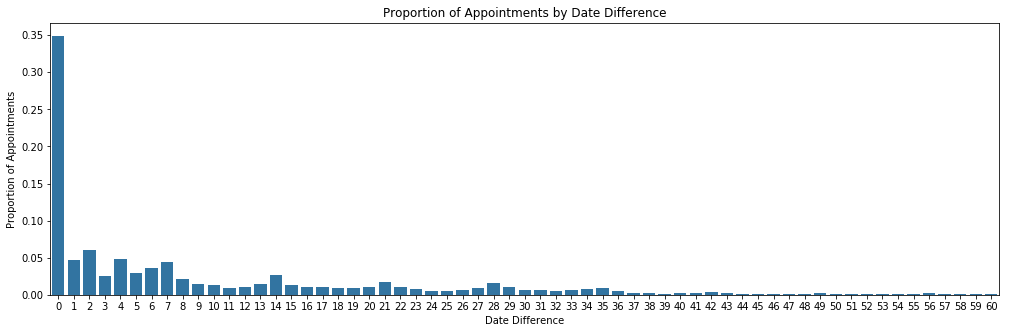

In [34]:
# Visualize the distribution using Seaborn
fig = plt.subplots(figsize=(17, 5))
sb.barplot(
    data = sched_dist.query('date_diff <= 60'),
    x = 'date_diff',
    y = 'proportion',
    color = sb.color_palette()[0]
);

# Labels and titles
plt.xlabel('Date Difference')
plt.ylabel('Proportion of Appointments')
plt.title('Proportion of Appointments by Date Difference');

NOTE: We only included data where `date_diff` is 60 or less, in order to make the visualization easier to view.

This bar graph clearly shows that a hugely disproportional number of appointments (35% to be specific) are scheduled on the day of the appointment i.e. date_diff = 0.

And despite some patients scheduling their appointment as many as 179 days (~6 months) in advance, nearly two-thirds of all appointments (64%) are scheduled one week in advance or earlier, 90% of appointments are scheduled 30 days in advance or earlier, and 98% are scheduled 60 days in advance or earlier.

Next, we'll look at how the No-show rate varies by date_diff.

In [35]:
# Group by date_diff and for each value calculate the mean of no_show_int
date_diff_rates = df_clean.groupby('date_diff', as_index=False).no_show_int.mean()
date_diff_rates.head()

,date_diff,no_show_int
0,0,0.046471
1,1,0.213505
2,2,0.238216
3,3,0.235294
4,4,0.232703


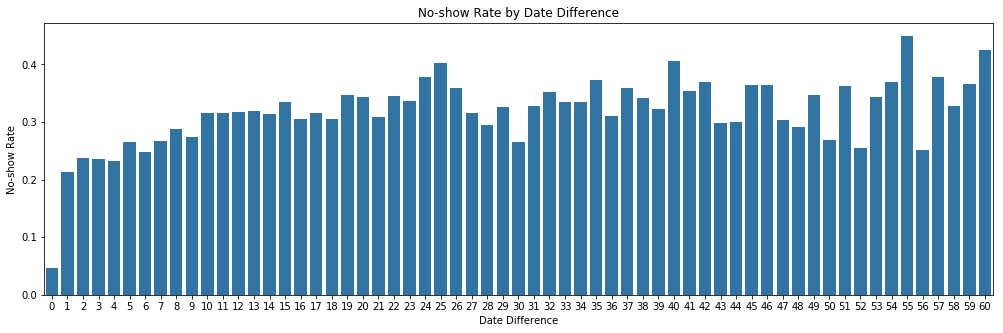

In [36]:
fig = plt.subplots(figsize=(17, 5))
sb.barplot(
    data = date_diff_rates.query('date_diff <= 60'),
    x = 'date_diff',
    y = 'no_show_int',
    color = sb.color_palette()[0]
);

# Labels and titles
plt.xlabel('Date Difference')
plt.ylabel('No-show Rate')
plt.title('No-show Rate by Date Difference');

Earlier, we saw that 35% of all appointments are scheduled on the day of.

This visualization shows us that those appointments have a No-show rate of only 5%, which is much lower than the overall rate of around 20%.

This bar chart also shows us that for all values of date_diff between 2 and 60 days, the No-show rate is between 20% and 50%.

Lastly, let's compare the histograms of date_diff for Shows and No-shows

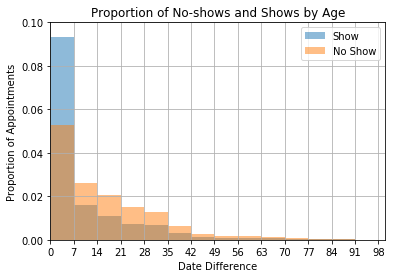

In [37]:
# Distribution of scheduled_appointment_diff for shows and no shows
df_clean[show].date_diff.hist(alpha=0.5, density=True, bins=range(0, max(df_clean[show].age) + 7, 7));
df_clean[no_show].date_diff.hist(alpha=0.5, density=True, bins=range(0, max(df_clean[no_show].age) + 7, 7));
plt.xticks(np.arange(0, 100, 7))
plt.axis([0, 100, 0, 0.1])
plt.legend(['Show', 'No Show']);

# Labels and titles
plt.xlabel('Date Difference')
plt.ylabel('Proportion of Appointments')
plt.title('Proportion of No-shows and Shows by Age');

In [38]:
df_clean[show].date_diff.mean(), df_clean[no_show].date_diff.mean()

(8.754758692620767, 15.835484449224701)

This visualization further reinforces the finding that patients who schedule their appointment more than a few days in advance are more likely to no-show.

### Question #5: SMS Reminders
**Do SMS reminders decrease no-show rates?**

Analyzing the impact of SMS reminders on No-show rates is interesting because it's one possible solution to the problem of people not showing up to their appointments. If we find evidence that SMS reminders do help lower no-show rates, then it opens the door to experimenting with other types of reminders like phone calls, email, snail mail, etc.

In [39]:
# Proportion of all patients that received an SMS reminder for their appointment
df_clean.sms_received.mean()

0.3210430596900137

In [40]:
# Proportion of SMS recipients by Show and No-show
df_clean[show].sms_received.mean(), df_clean[no_show].sms_received.mean()

(0.29133742220005215, 0.43846912252397596)

29% of people who Showed had received an SMS reminder, while 44% of people who No Showed had received an SMS reminder.

On the surface, the data seems to indicate that people who receive SMS reminders are more likely to not show up for their appointment, which is the opposite of what we would have expected.

However, it's also possible that people who are more likely to no-show in the first place (due to some other underlying factor) are more likely to receive SMS reminders. 

Let's dig deeper to find out.

First, we should ask what factor(s) determines whether or not someone receives an SMS?

One possibility is that SMS reminders are sent based on how far out an appointment was scheduled i.e. our date_diff column. For example, people who schedule an appointment the day of or the day before the appointment probably might not need an SMS reminder, while people who scheduled their appointment two weeks prior would benefit from receiving them.

Let's start by looking at the proportion of people who receive an SMS reminder based on when they scheduled their appointment.

In [41]:
# Group by date_diff to see the proportion of 
sms_sched = df_clean.groupby('date_diff', as_index=False).sms_received.mean()
sms_sched.head()

,date_diff,sms_received
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.331019
4,4,0.577316


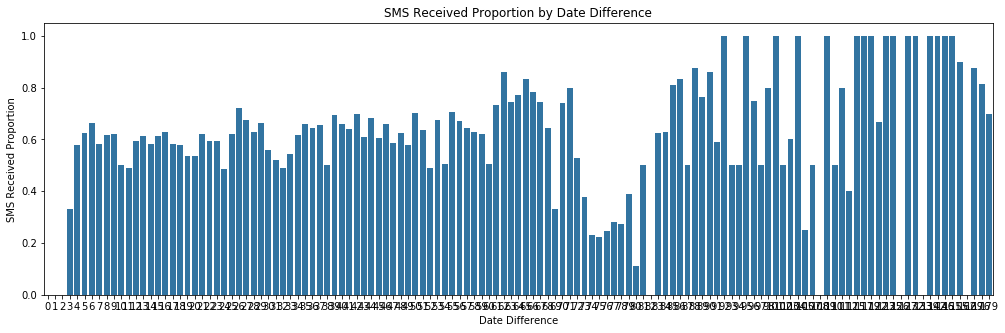

In [42]:
fig = plt.subplots(figsize=(17, 5))
sb.barplot(
    data = sms_sched,
    x = 'date_diff',
    y = 'sms_received',
    color = sb.color_palette()[0]
);

# Labels and titles
plt.xlabel('Date Difference')
plt.ylabel('SMS Received Proportion')
plt.title('SMS Received Proportion by Date Difference');

What stands out in this table and its visualization is that people who schedule their appointment 0, 1, or 2 days in advance do not receive any SMS reminders.

Earlier in our analysis for Date Difference, we created a table (see `sched_dist`) showing that nearly half (46%) of all appointments are scheduled 2 days in advance or earlier.

That tells us that looking at SMS reminder data for all appointments can be misleading. Combined with data from the previous section, we now know the following:
* 35% of patients schedule their appointment the day of
* None of those patients receive an SMS reminder
* The No-show rate of those patients is a very low 4.6%

In that case, let's see how the No-show rate is affected by SMS reminders after filtering for only those patients who are actually eligible to receive SMS reminders i.e. those who schedule their appointment 3 or more days in advance.

In [43]:
df_clean.query('date_diff >= 3').groupby('sms_received', as_index=False).no_show_int.mean()

,sms_received,no_show_int
0,0,0.326949
1,1,0.275745


For patients who are "SMS eligible" i.e. scheduled their appointment 3 or more days in advance, we can see that SMS reminders are indeed effective in lowering the No-show rate. Those who didn't receive an SMS reminder had a No-show rate of 33%, while the No-show rate for SMS reminder recipients was 28%.

This indicates that SMS reminders should continue to be sent, especially to patient segments that we've shown are more likely to no-show e.g. younger patients, patients who scheduled their appointment many weeks in advance, etc.

<a id='conclusions'></a>
## Conclusions

In summary, in this notebook we analyzed 5 different independent variables — Gender, Day of Week, Age, Date Difference, and SMS Reminders – and their effect (or lack thereof) on our No-show dependent variable.

We found that Gender and Day of Week had little to no effect on No-show rates, and we saw a minor difference in No-show rates based on patient age.

However, the most notable findings were for Date Difference and SMS Reminders.

We found that the distribution for Date Difference was highly skewed to the right:
* 35% of appointments were scheduled the day of (date_diff = 0).
* 64% of appointments were scheduled 7 days (i.e. 1 week) or less in advance.
* 90% of appointments were scheduled 30 days (~1 month) or less in advance.
* 98% of appointments were scheduled 60 days (~2 months) or less in advance.
* The maximum value for date_diff was 179 days (~6 months).

And for SMS reminders, we saw that among patients who are eligible to receive SMS reminders (i.e. scheduled their appointment 3 or more days in advance), SMS receipients had a 16% lower no-show rate. This indicates that SMS reminders do work, and that hospitals should conduct additional experiments with SMS reminders (e.g. A/B testing) to further demonstrate and optimize their effectiveness in reducing no-shows. Hospitals should also consider experimenting with other forms of reminders like phone, email, snail mail, etc.

### Limitations

The biggest caveat with this data is the range of appointment dates, which is quite small. You can see in the cell below that the earliest appointment in this dataset is for April 29, 2016 and the latest appointment is for June 8, 2018. That is less than less than 2 months.

In [44]:
df_clean.appointment_day.min(), df_clean.appointment_day.max()

(Timestamp('2016-04-29 00:00:00'), Timestamp('2016-06-08 00:00:00'))

This shorter date range could result in the following biases:
* There's a greater probability that our findings are due to chance (i.e. from random short-term fluctuations), and would not hold for an entire calendar year's worth or more of appointment data.
* There could be seasonal effects for a full year of data that are not fully reflected in the <2 months of data in this dataset.
* The sample of patients from these <2 months may not be representative of all the patients in the area that would visit the hospital in a calendar year.